# Classification modeling
---

# TODO:
- interpret AUC curves
- can you add CUTI index to the plots of misclassified data? curious about whether misclassifications are concentrated around CUTI values near 0.
- question whether this notebook is too long.... I could put the log reg models and decision tree models into their own notebooks but it might make model comparison more annoying

---

For my baseline model, I need to ask myself what I'm actually trying to do and whether my audience cares more about accuracy or interpretation. In academic settings and Earth sciences, I prefer to prioritize interpretation since I'm working with real-world concepts and I'd like to be able to use these methods to learn about the oceanographic processes at play here. For this reason, I'll be using scikit-learn's Logistic Regression model, a straightforward classification model that prioritizes interpretability over accuracy. There are several assumptions we make about our data when we use this model, including assuming that our independent variables are independent *of each other*. 

However, I know this isn't the case in my data and the variables are strongly correlated with each other. Out of curiosity, I'm going to make a model with each feature individually as one way to avoid the multicollinearity, and then use polynomial features to engineer some interaction features and utilize regularization techniques to reduce the effect of multicollinearity. 

In [76]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import random

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, plot_confusion_matrix, classification_report, plot_roc_curve
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text

random.seed(42)

---
### Load the data

In [77]:
df = pd.read_csv('../../coastal_upwelling_output/clean_dataframe.csv')

In [78]:
df

,time,density,practical_salinity,seawater_temperature,sea_surface_temperature,CUTI,upwelling,upwelling_multi
0,2017-01-01 00:00:00,1027.258767,33.916755,7.766451,11.273,1.731,1,1
1,2017-01-01 00:01:00,1027.260164,33.917475,7.760876,11.268,1.731,1,1
2,2017-01-01 00:02:00,1027.258920,33.917249,7.767207,11.267,1.731,1,1
3,2017-01-01 00:03:00,1027.258097,33.916964,7.771317,11.267,1.731,1,1
4,2017-01-01 00:04:00,1027.258173,33.917076,7.771017,11.278,1.731,1,1
...,...,...,...,...,...,...,...,...
329194,2017-09-15 23:55:00,1027.366397,33.960043,7.866675,15.198,-0.194,0,0
329195,2017-09-15 23:56:00,1027.366555,33.960125,7.866182,15.171,-0.194,0,0
329196,2017-09-15 23:57:00,1027.365319,33.959667,7.872284,15.158,-0.194,0,0
329197,2017-09-15 23:58:00,1027.364325,33.959192,7.876495,15.199,-0.194,0,0


This dataframe is over 300,000 observations, which I'm hesitant to pass to a model right away. I'm going to resample down to a small size at first, and then add data back in once the workflow is established.

In [79]:
df['time'] = pd.to_datetime(df['time'])

In [80]:
df_resampled = df.resample('10T', on='time').mean().dropna(how='all').reset_index().drop(columns=['CUTI', 'density'])
print(df_resampled.shape)

(35413, 6)


In [81]:
indices_to_drop = df_resampled.loc[df_resampled['upwelling_multi'] == 0].index

In [82]:
df_resampled = df_resampled.drop(index=indices_to_drop, axis=0).reset_index(drop=True)

In [83]:
df_resampled

,time,practical_salinity,seawater_temperature,sea_surface_temperature,upwelling,upwelling_multi
0,2017-01-01 00:00:00,33.917250,7.770317,11.2720,1.0,1.0
1,2017-01-01 00:10:00,33.918353,7.765881,11.2686,1.0,1.0
2,2017-01-01 00:20:00,33.923073,7.704422,11.2673,1.0,1.0
3,2017-01-01 00:30:00,33.924400,7.686089,11.2686,1.0,1.0
4,2017-01-01 00:40:00,33.925316,7.688232,11.2666,1.0,1.0
...,...,...,...,...,...,...
17705,2017-09-13 23:10:00,33.959982,7.891654,14.0770,1.0,1.0
17706,2017-09-13 23:20:00,33.961239,7.887042,14.2193,1.0,1.0
17707,2017-09-13 23:30:00,33.950657,7.962811,14.2666,1.0,1.0
17708,2017-09-13 23:40:00,33.947708,7.990365,14.3493,1.0,1.0


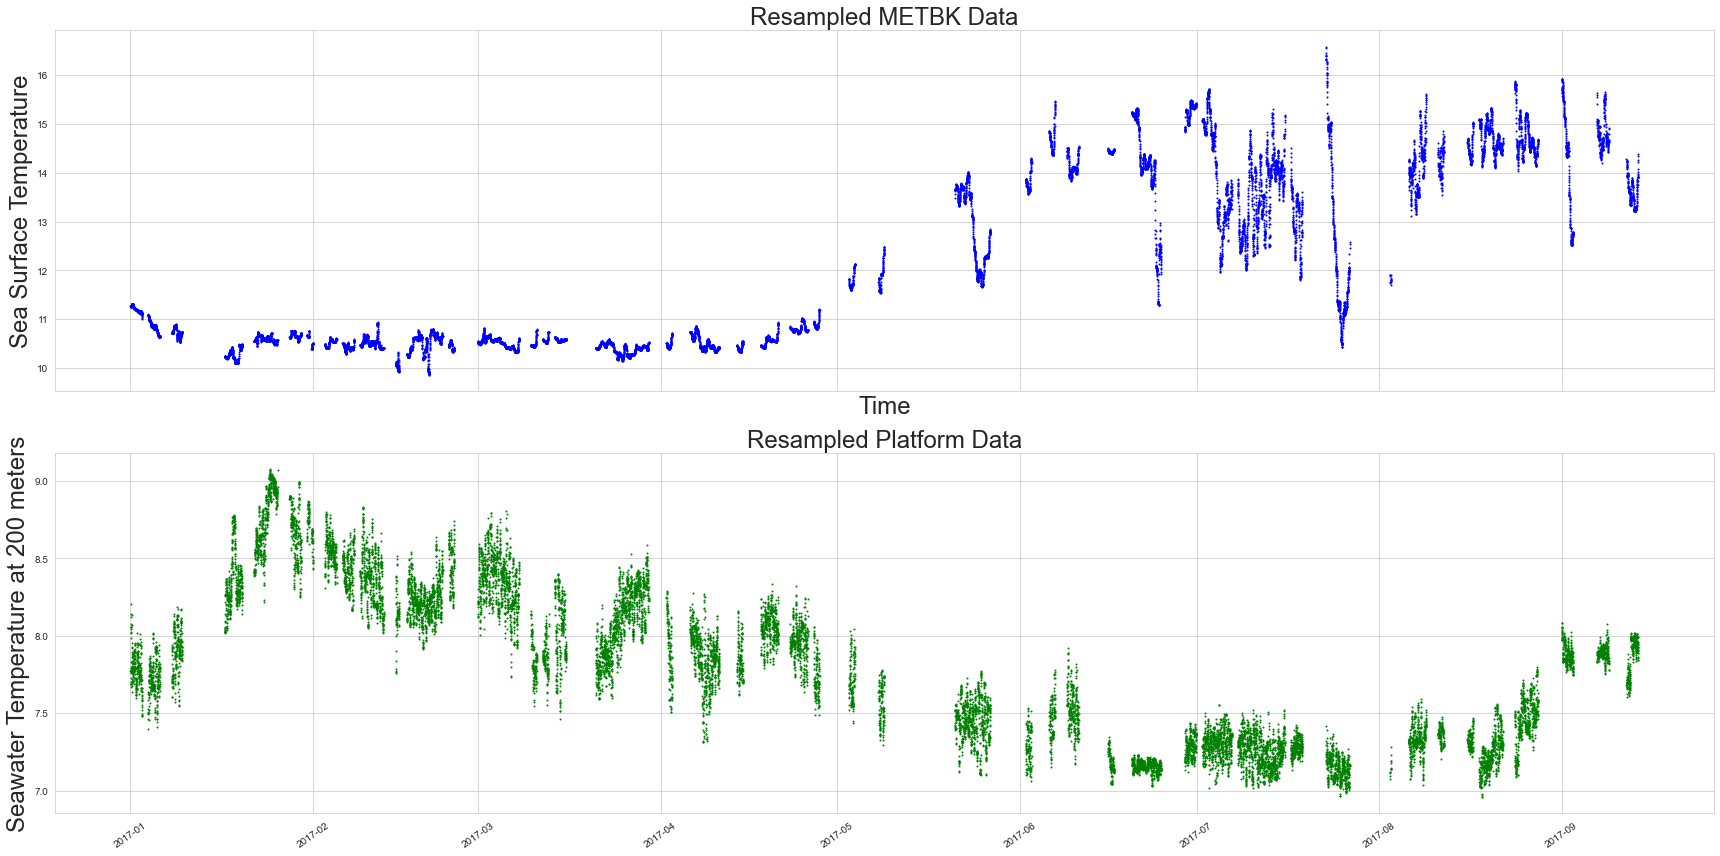

In [84]:
fig, (ax2, ax1) = plt.subplots(2,1, sharex=True, figsize = (24, 12)) 
ax1.scatter(x=df_resampled['time'], y=df_resampled['seawater_temperature'], c='g', s=1)
ax1.set_ylabel('Seawater Temperature at 200 meters', size=24)
ax1.set_title('Resampled Platform Data', size=24)

ax2.scatter(x=df_resampled['time'], y=df_resampled['sea_surface_temperature'], c='b', s=1)
ax2.set_xlabel('Time', size=24)
ax2.set_ylabel('Sea Surface Temperature', size=24)
ax2.set_title('Resampled METBK Data', size=24)

plt.xticks(rotation=35);
plt.tight_layout()

In [85]:
df_resampled

,time,practical_salinity,seawater_temperature,sea_surface_temperature,upwelling,upwelling_multi
0,2017-01-01 00:00:00,33.917250,7.770317,11.2720,1.0,1.0
1,2017-01-01 00:10:00,33.918353,7.765881,11.2686,1.0,1.0
2,2017-01-01 00:20:00,33.923073,7.704422,11.2673,1.0,1.0
3,2017-01-01 00:30:00,33.924400,7.686089,11.2686,1.0,1.0
4,2017-01-01 00:40:00,33.925316,7.688232,11.2666,1.0,1.0
...,...,...,...,...,...,...
17705,2017-09-13 23:10:00,33.959982,7.891654,14.0770,1.0,1.0
17706,2017-09-13 23:20:00,33.961239,7.887042,14.2193,1.0,1.0
17707,2017-09-13 23:30:00,33.950657,7.962811,14.2666,1.0,1.0
17708,2017-09-13 23:40:00,33.947708,7.990365,14.3493,1.0,1.0


---
### Checking feature correlation

One of the big assumptions we make when building logistic regression models is that our independent features are independent of each other. We can print out a heatmap to check whether our features are correlated to each other or not.

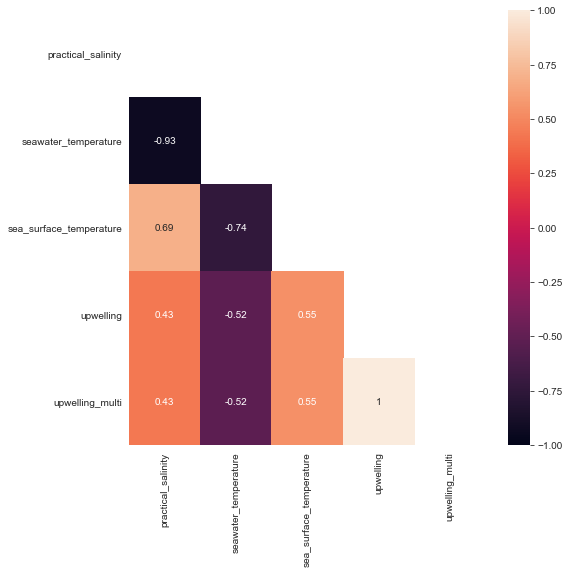

In [86]:
plt.figure(figsize=(8,8))

corr = df_resampled.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))

sns.heatmap(df_resampled.corr(), annot=True, vmin=-1, vmax=1, mask=mask);

Yup, looks like our features are correlated with each other! We can also tell from this heatmap that seawater temperature collected by the 200 meter platform is most strongly correlated to upwelling of all our features. I'll build a logistic regression model without addressing the multicollinearity first, and then attempt to improve it by using PolynomialFeatures and ridge and lasso penalties. 

c:\users\derya\appdata\local\programs\python\python39\lib\site-packages\seaborn\distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
c:\users\derya\appdata\local\programs\python\python39\lib\site-packages\seaborn\distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


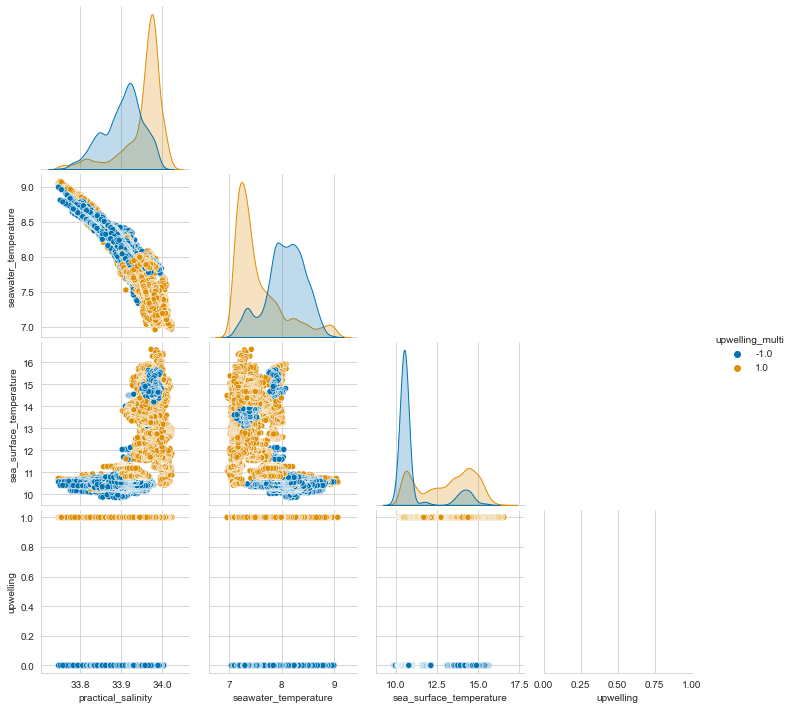

In [87]:
sns.pairplot(df_resampled, corner=True, hue='upwelling_multi', palette='colorblind');

---
## Logistic regression classifiers

### Using only one feature

This sections is on building a model with only seawater temperature from the 200 meter platform as the prediction.

In [88]:
X = df_resampled['seawater_temperature']
y = df_resampled['upwelling_multi']

y.value_counts(normalize=True)

 1.0    0.508809
-1.0    0.491191
Name: upwelling_multi, dtype: float64

If we created a null model that labeled all predictions as the majority class, we'd be correct about 61.96% of the time! This is the accuracy I'm hoping to beat with logistic regression or decision tree models.

In [89]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

Create a pipeline with StandardScaler and LogisticRegression

In [90]:
pipe = Pipeline([
    ('sc', StandardScaler()),
    ('logreg', LogisticRegression())
])

In [91]:
pipe.fit(X_train.values.reshape(-1, 1), y_train)

Pipeline(steps=[('sc', StandardScaler()), ('logreg', LogisticRegression())])

In [92]:
print(f'Train accuracy: {pipe.score(X_train.values.reshape(-1, 1), y_train)}')
print(f'Test accuracy: {pipe.score(X_test.values.reshape(-1, 1), y_test)}')

Train accuracy: 0.7841439542237615
Test accuracy: 0.7859078590785907


In [93]:
print(cross_val_score(pipe, X_train.values.reshape(-1, 1), y_train).mean())
print(cross_val_score(pipe, X_test.values.reshape(-1, 1), y_test).mean())

0.783843654633589
0.7856859369221155


In [94]:
logreg = pipe.named_steps['logreg']
print(f'LogReg Intercept: {logreg.intercept_}')
print(f'LogReg Coef: {logreg.coef_}')

LogReg Intercept: [0.01660441]
LogReg Coef: [[-1.29733943]]


This model performs better than our baseline, woohoo! But maybe we can do better with polynomial features.

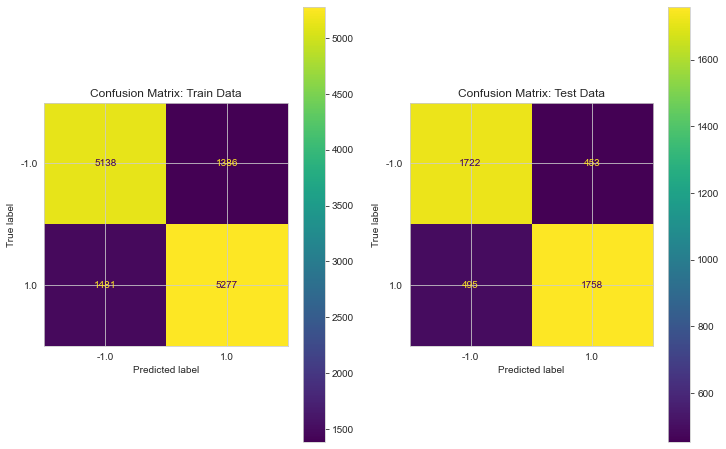

In [95]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))

plot_confusion_matrix(pipe, X_train.values.reshape(-1, 1), y_train, ax=ax1)
ax1.set_title('Confusion Matrix: Train Data')

plot_confusion_matrix(pipe, X_test.values.reshape(-1, 1), y_test, ax=ax2)
ax2.set_title('Confusion Matrix: Test Data');

In [96]:
test_preds = pipe.predict(X_test.values.reshape(-1, 1))
print(classification_report(y_test, test_preds))

              precision    recall  f1-score   support

        -1.0       0.78      0.79      0.78      2175
         1.0       0.80      0.78      0.79      2253

    accuracy                           0.79      4428
   macro avg       0.79      0.79      0.79      4428
weighted avg       0.79      0.79      0.79      4428



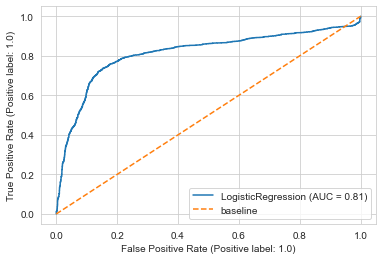

In [97]:
# ROC curve
plot_roc_curve(logreg, X_test.values.reshape(-1, 1), y_test)

# add worst case scenario line
plt.plot([0,1],[0,1], label='baseline', linestyle='--')

# add a legend
plt.legend();
# want AUC (area under curve) to be as close to 1 as possible

---
### Using PolynomialFeatures

Now let's add those features back in and use feature interactions combined with regularization to try upping the accuracy while accounting for the multicollinearity.

An easy way to get a variety of feature interactions is using sklearn's PolynomialFeatures function. There are four features in this model, so I'll set the degree to 4 so that there will be an engineered feature that includes all 4 of the original features. 

In [98]:
X = df_resampled.drop(columns=['upwelling', 'upwelling_multi', 'time'])
y = df_resampled['upwelling_multi']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

In [99]:
pipe = Pipeline([
    ('poly', PolynomialFeatures(degree=2, interaction_only=False, include_bias=False)),
    ('sc', StandardScaler()),
    ('logreg', LogisticRegression(max_iter=1000, solver='liblinear'))
])

pipe_params = {
    'logreg__penalty':['l1', 'l2'],
    'logreg__C': np.linspace(0.001, 1, 10)
}

gs_lr = GridSearchCV(pipe, pipe_params, cv=5, verbose=1, return_train_score=True)

gs_lr.fit(X_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('poly',
                                        PolynomialFeatures(include_bias=False)),
                                       ('sc', StandardScaler()),
                                       ('logreg',
                                        LogisticRegression(max_iter=1000,
                                                           solver='liblinear'))]),
             param_grid={'logreg__C': array([0.001, 0.112, 0.223, 0.334, 0.445, 0.556, 0.667, 0.778, 0.889,
       1.   ]),
                         'logreg__penalty': ['l1', 'l2']},
             return_train_score=True, verbose=1)

In [100]:
print(f'Best parameters: {gs_lr.best_params_}')
print(f'Best score: {gs_lr.best_score_}')

Best parameters: {'logreg__C': 1.0, 'logreg__penalty': 'l1'}
Best score: 0.8184005876724815


Now that we have the best parameters, we can create a logistic regression model with these parameters and see what the coefficients are for our poly features.

In [101]:
print(gs_lr.cv_results_['mean_train_score'].mean())
print(gs_lr.cv_results_['mean_test_score'].mean())

0.8088399958370701
0.8085605184191793


In [102]:
print(f'Train accuracy: {gs_lr.score(X_train, y_train)}')
print(f'Test accuracy: {gs_lr.score(X_test, y_test)}')

Train accuracy: 0.8185514229784671
Test accuracy: 0.821364046973803


Question to self: do the coefficients need to be exponentiated to get their actual values, since the logistic regression model uses the logit function to transform the data?

In [103]:
gs_lr.predict(X_train)

array([ 1.,  1., -1., ..., -1., -1., -1.])

In [104]:
gs_lr.best_estimator_['logreg'].coef_

array([[-9.02525515e-02, -1.28034896e+01, -6.16193136e-05,
        -3.68342409e-04, -1.69703159e+01,  0.00000000e+00,
         2.51935563e+01,  6.81228917e+00, -8.36635570e+00]])

In [105]:
poly_features = gs_lr.estimator.named_steps['poly'].fit(X_train).get_feature_names(X.columns)
coefs = gs_lr.best_estimator_['logreg'].coef_[0]

In [106]:
sorted(list(zip(poly_features, coefs)), key=lambda x: x[1])[:10]

[('practical_salinity seawater_temperature', -16.970315947412022),
 ('seawater_temperature', -12.803489646809885),
 ('sea_surface_temperature^2', -8.366355701035666),
 ('practical_salinity', -0.09025255149622222),
 ('practical_salinity^2', -0.0003683424091649124),
 ('sea_surface_temperature', -6.161931362651492e-05),
 ('practical_salinity sea_surface_temperature', 0.0),
 ('seawater_temperature sea_surface_temperature', 6.812289169362725),
 ('seawater_temperature^2', 25.193556337469076)]

In [107]:
sorted(list(zip(poly_features, coefs)), key=lambda x: x[1])[-10:]

[('practical_salinity seawater_temperature', -16.970315947412022),
 ('seawater_temperature', -12.803489646809885),
 ('sea_surface_temperature^2', -8.366355701035666),
 ('practical_salinity', -0.09025255149622222),
 ('practical_salinity^2', -0.0003683424091649124),
 ('sea_surface_temperature', -6.161931362651492e-05),
 ('practical_salinity sea_surface_temperature', 0.0),
 ('seawater_temperature sea_surface_temperature', 6.812289169362725),
 ('seawater_temperature^2', 25.193556337469076)]

In [108]:
gs_lr_train_preds = gs_lr.predict(X_train)
gs_lr_test_preds = gs_lr.predict(X_test)

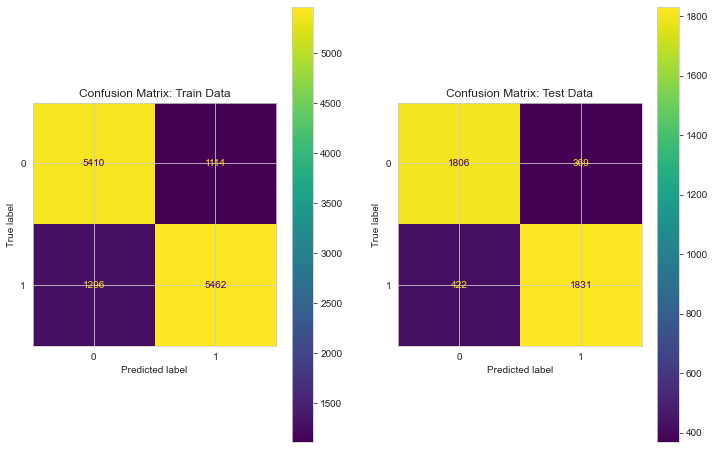

In [109]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))

cm = confusion_matrix(y_train, gs_lr_train_preds)
ConfusionMatrixDisplay(cm).plot(ax=ax1)
ax1.set_title('Confusion Matrix: Train Data')

cm = confusion_matrix(y_test, gs_lr_test_preds)
ConfusionMatrixDisplay(cm).plot(ax=ax2)
ax2.set_title('Confusion Matrix: Test Data');

Looks like our false negatives outnumber our false positives

In [110]:
print(classification_report(y_test, gs_lr_test_preds))

              precision    recall  f1-score   support

        -1.0       0.81      0.83      0.82      2175
         1.0       0.83      0.81      0.82      2253

    accuracy                           0.82      4428
   macro avg       0.82      0.82      0.82      4428
weighted avg       0.82      0.82      0.82      4428



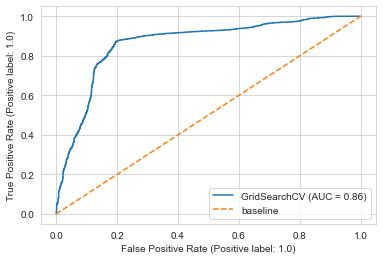

In [111]:
# ROC curve
plot_roc_curve(gs_lr, X_test, y_test)

# add worst case scenario line
plt.plot([0,1],[0,1], label='baseline', linestyle='--')

# add a legend
plt.legend();
# want AUC (area under curve) to be as close to 1 as possible

#### Explore misclassified data

In [112]:
# Get indices of misclassified data source: https://stackoverflow.com/questions/25551977/retrieve-misclassified-documents-using-scikitlearn
misclass_ind_lr = np.where(y_test != gs_lr_test_preds)
misclass_ind_lr

(array([   8,   13,   32,   33,   42,   43,   45,   46,   50,   58,   59,
          69,   76,   87,   96,  100,  112,  119,  121,  122,  125,  128,
         133,  147,  154,  163,  177,  178,  181,  183,  187,  188,  189,
         196,  206,  230,  233,  239,  241,  245,  248,  250,  251,  256,
         265,  268,  271,  277,  278,  282,  284,  291,  298,  300,  301,
         302,  303,  315,  322,  333,  335,  342,  350,  353,  360,  363,
         371,  382,  392,  393,  402,  415,  430,  439,  445,  461,  463,
         469,  471,  472,  481,  483,  484,  485,  486,  487,  489,  492,
         496,  497,  499,  502,  514,  516,  521,  522,  533,  535,  537,
         538,  541,  543,  564,  567,  568,  586,  596,  597,  604,  605,
         609,  636,  643,  647,  649,  656,  663,  667,  671,  672,  674,
         690,  695,  696,  701,  708,  711,  713,  722,  739,  742,  753,
         757,  760,  761,  763,  769,  774,  775,  778,  781,  789,  790,
         792,  795,  797,  798,  804, 

In [113]:
X_test

,practical_salinity,seawater_temperature,sea_surface_temperature
4356,33.810582,8.569762,10.569100
6771,33.901309,8.176016,10.408333
13390,33.960256,7.358609,13.244500
640,33.887565,8.062618,10.852900
15793,33.978303,7.219339,14.407000
...,...,...,...
6266,33.913067,7.920707,10.436900
7352,33.913761,8.193605,10.428438
12260,33.969966,7.315469,15.025778
5944,33.920316,8.005209,10.549100


In [114]:
df_resampled

,time,practical_salinity,seawater_temperature,sea_surface_temperature,upwelling,upwelling_multi
0,2017-01-01 00:00:00,33.917250,7.770317,11.2720,1.0,1.0
1,2017-01-01 00:10:00,33.918353,7.765881,11.2686,1.0,1.0
2,2017-01-01 00:20:00,33.923073,7.704422,11.2673,1.0,1.0
3,2017-01-01 00:30:00,33.924400,7.686089,11.2686,1.0,1.0
4,2017-01-01 00:40:00,33.925316,7.688232,11.2666,1.0,1.0
...,...,...,...,...,...,...
17705,2017-09-13 23:10:00,33.959982,7.891654,14.0770,1.0,1.0
17706,2017-09-13 23:20:00,33.961239,7.887042,14.2193,1.0,1.0
17707,2017-09-13 23:30:00,33.950657,7.962811,14.2666,1.0,1.0
17708,2017-09-13 23:40:00,33.947708,7.990365,14.3493,1.0,1.0


In [115]:
df_resampled.iloc[X_test.index]['time']

4356    2017-02-24 08:30:00
6771    2017-03-26 03:00:00
13390   2017-07-11 02:20:00
640     2017-01-08 10:40:00
15793   2017-08-18 16:30:00
                ...        
6266    2017-03-22 14:50:00
7352    2017-04-02 03:50:00
12260   2017-07-02 06:00:00
5944    2017-03-15 09:10:00
4002    2017-02-20 21:30:00
Name: time, Length: 4428, dtype: datetime64[ns]

In [116]:
X_test_times = df_resampled.iloc[X_test.index]['time']

In [117]:
X_test_times.iloc[misclass_ind_lr]

7380    2017-04-02 08:30:00
10933   2017-06-10 00:50:00
11047   2017-06-10 19:50:00
3178    2017-02-11 19:50:00
3143    2017-02-11 14:00:00
                ...        
15228   2017-08-07 18:20:00
15164   2017-08-07 07:40:00
14982   2017-08-06 01:20:00
3277    2017-02-12 12:20:00
7352    2017-04-02 03:50:00
Name: time, Length: 791, dtype: datetime64[ns]

In [118]:
pd.DataFrame(X_test_times.iloc[misclass_ind_lr]).reset_index(drop=True)

,time
0,2017-04-02 08:30:00
1,2017-06-10 00:50:00
2,2017-06-10 19:50:00
3,2017-02-11 19:50:00
4,2017-02-11 14:00:00
...,...
786,2017-08-07 18:20:00
787,2017-08-07 07:40:00
788,2017-08-06 01:20:00
789,2017-02-12 12:20:00


In [119]:
frames_lr = [pd.DataFrame(X_test_times.iloc[misclass_ind_lr]), X_test.iloc[misclass_ind_lr], pd.DataFrame(y_test.iloc[misclass_ind_lr])]
misclass_df_lr = pd.concat(frames_lr, axis=1)

In [120]:
misclass_df_lr

,time,practical_salinity,seawater_temperature,sea_surface_temperature,upwelling_multi
7380,2017-04-02 08:30:00,33.919211,7.986226,10.404445,1.0
10933,2017-06-10 00:50:00,33.946293,7.458397,14.052800,-1.0
11047,2017-06-10 19:50:00,33.961441,7.323193,14.288500,-1.0
3178,2017-02-11 19:50:00,33.891388,8.172834,10.626625,1.0
3143,2017-02-11 14:00:00,33.828913,8.417649,10.523250,1.0
...,...,...,...,...,...
15228,2017-08-07 18:20:00,33.974770,7.332205,13.570700,-1.0
15164,2017-08-07 07:40:00,33.982144,7.309281,13.534900,-1.0
14982,2017-08-06 01:20:00,33.960173,7.331028,14.099100,-1.0
3277,2017-02-12 12:20:00,33.812369,8.524747,10.381500,1.0


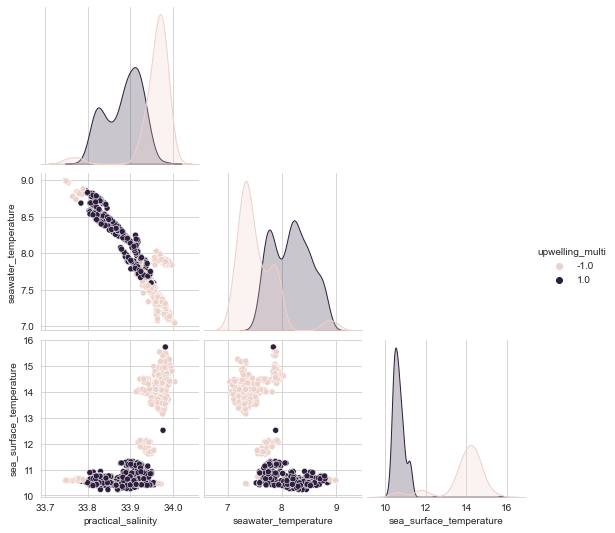

In [121]:
sns.pairplot(misclass_df_lr, corner=True, hue='upwelling_multi');

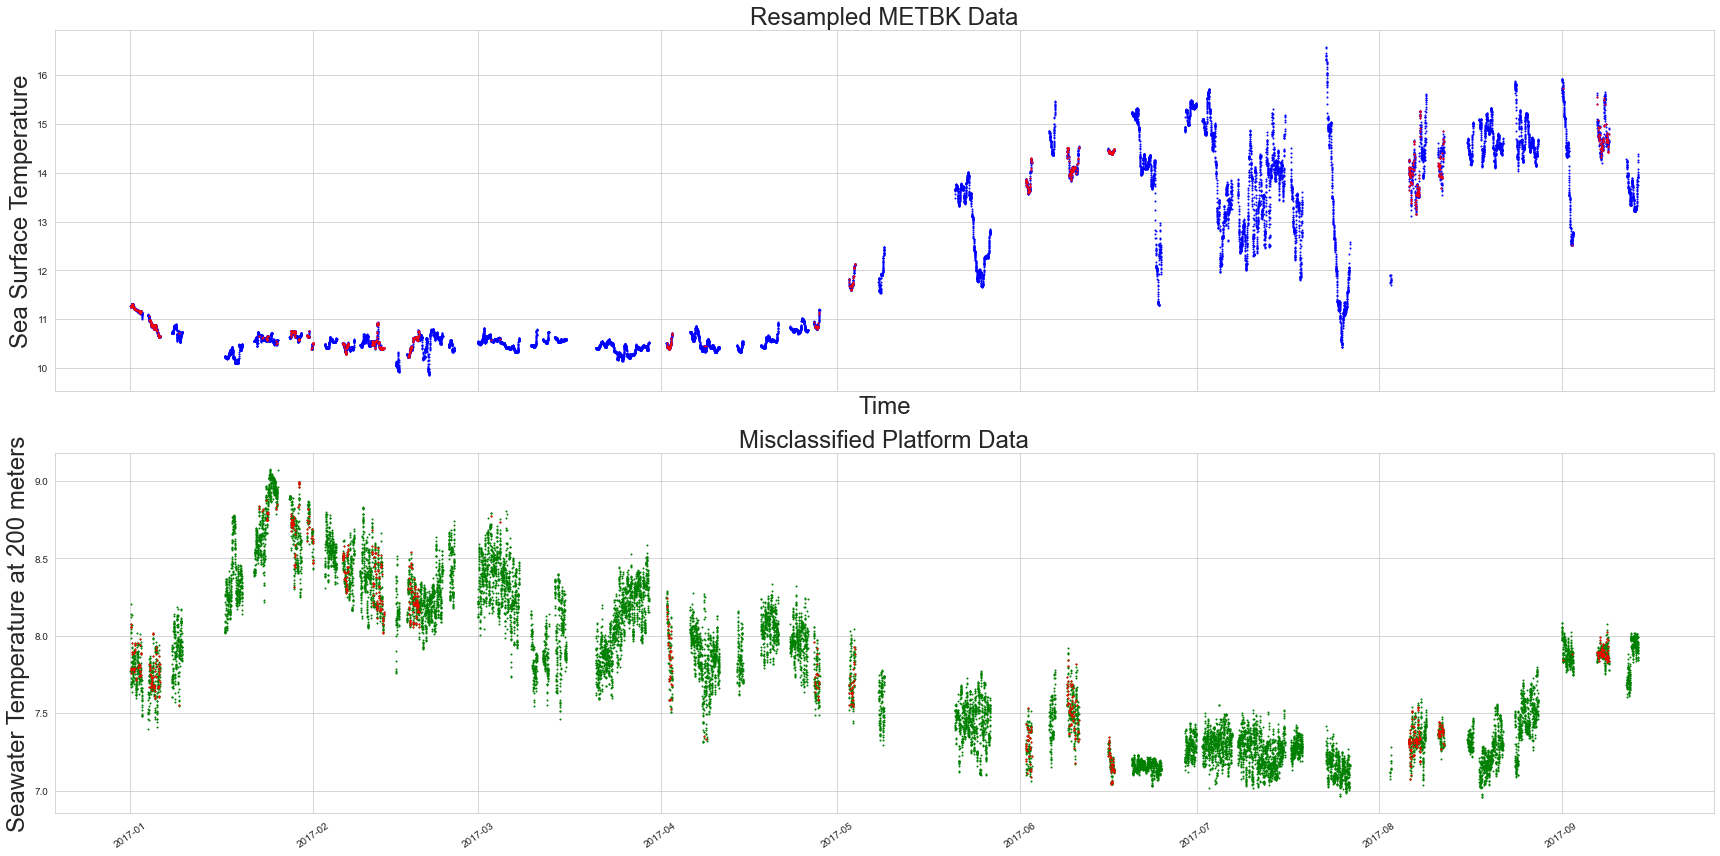

In [122]:
fig, (ax2, ax1) = plt.subplots(2,1, sharex=True, figsize = (24, 12)) 
ax1.scatter(x=df_resampled['time'], y=df_resampled['seawater_temperature'], c='g', s=1)
ax1.set_ylabel('Seawater Temperature at 200 meters', size=24)
ax1.set_title('Misclassified Platform Data', size=24)

ax1.scatter(x=misclass_df_lr['time'], y=misclass_df_lr['seawater_temperature'], c='r', s=1)

ax2.scatter(x=df_resampled['time'], y=df_resampled['sea_surface_temperature'], c='b', s=1)
ax2.set_xlabel('Time', size=24)
ax2.set_ylabel('Sea Surface Temperature', size=24)
ax2.set_title('Resampled METBK Data', size=24)

ax2.scatter(x=misclass_df_lr['time'], y=misclass_df_lr['sea_surface_temperature'], c='r', s=1)



plt.xticks(rotation=35);
plt.tight_layout()

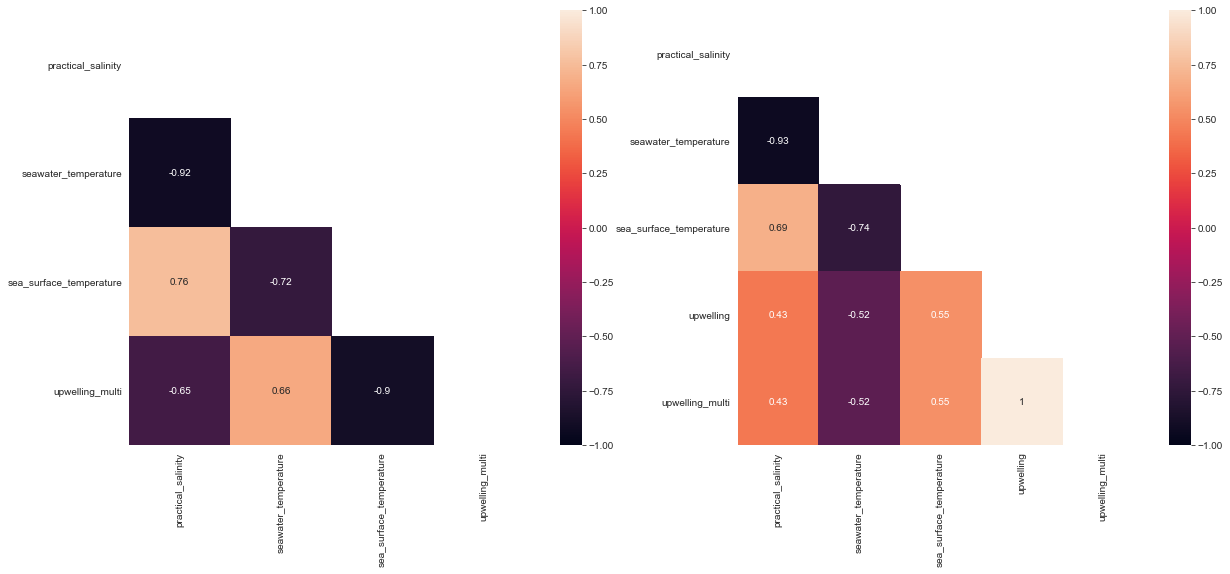

In [123]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,8))

corr = misclass_df_lr.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(misclass_df_lr.corr(), annot=True, vmin=-1, vmax=1, mask=mask, ax=ax1)

corr = df_resampled.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(df_resampled.corr(), annot=True, vmin=-1, vmax=1, mask=mask, ax=ax2);

---
### Decision tree classifiers
Decision trees come in a lot of different shapes, so it'd be best to use GridSearchCV to find the best parameters for a tree for upwelling classification.

In [124]:
X = df_resampled.drop(columns=['time', 'upwelling', 'upwelling_multi'])
y = df_resampled['upwelling_multi']

In [125]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

In [126]:
param_grid = {
    'max_depth': [5, 7, 9],
    'min_samples_split': [5, 10, 15, 20],
    'min_samples_leaf': [2, 3, 4, 5, 6],
    'ccp_alpha': [0, 0.01, 0.1, 1, 10]
}

gs_dt = GridSearchCV(estimator=DecisionTreeClassifier(),
                 param_grid=param_grid,
                 verbose=1,
                 cv=5)

%time gs_dt.fit(X_train, y_train)

Fitting 5 folds for each of 300 candidates, totalling 1500 fits
Wall time: 33.7 s


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
             param_grid={'ccp_alpha': [0, 0.01, 0.1, 1, 10],
                         'max_depth': [5, 7, 9],
                         'min_samples_leaf': [2, 3, 4, 5, 6],
                         'min_samples_split': [5, 10, 15, 20]},
             verbose=1)

In [127]:
gs_dt.best_estimator_

DecisionTreeClassifier(ccp_alpha=0, max_depth=9, min_samples_leaf=2,
                       min_samples_split=5)

In [128]:
print(f'Score on training set: {gs_dt.score(X_train, y_train)}')
print(f'Score on testing set: {gs_dt.score(X_test, y_test)}')

Score on training set: 0.9093510013552176
Score on testing set: 0.8893405600722674


In [129]:
gs_dt_train_preds = gs_dt.predict(X_train)
gs_dt_test_preds = gs_dt.predict(X_test)

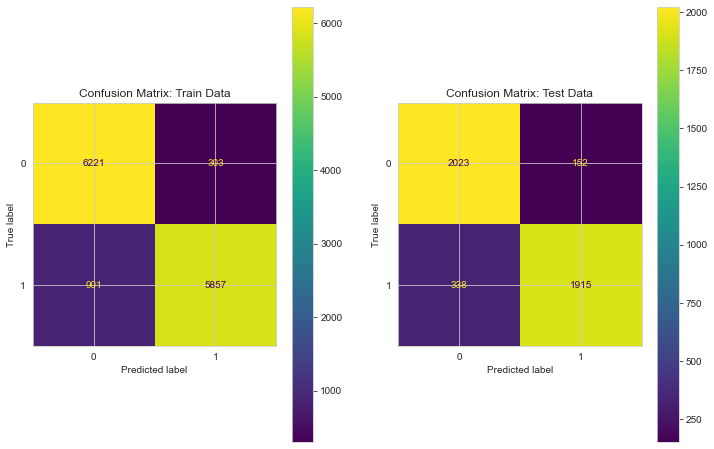

In [130]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))

cm = confusion_matrix(y_train, gs_dt_train_preds)
ConfusionMatrixDisplay(cm).plot(ax=ax1)
ax1.set_title('Confusion Matrix: Train Data')

cm = confusion_matrix(y_test, gs_dt_test_preds)
ConfusionMatrixDisplay(cm).plot(ax=ax2)
ax2.set_title('Confusion Matrix: Test Data');

In [131]:
print(gs_dt.best_estimator_.feature_importances_)
list(X_train.columns)

[0.09005668 0.15547046 0.75447286]


['practical_salinity', 'seawater_temperature', 'sea_surface_temperature']

We saw that `seawater_temperature` was the most strongly correlated feature to upwelling, but `sea_surface_temperature` ended up having the greatest feature importance. I want to trust the model on this, but I'm wondering why this happened. 

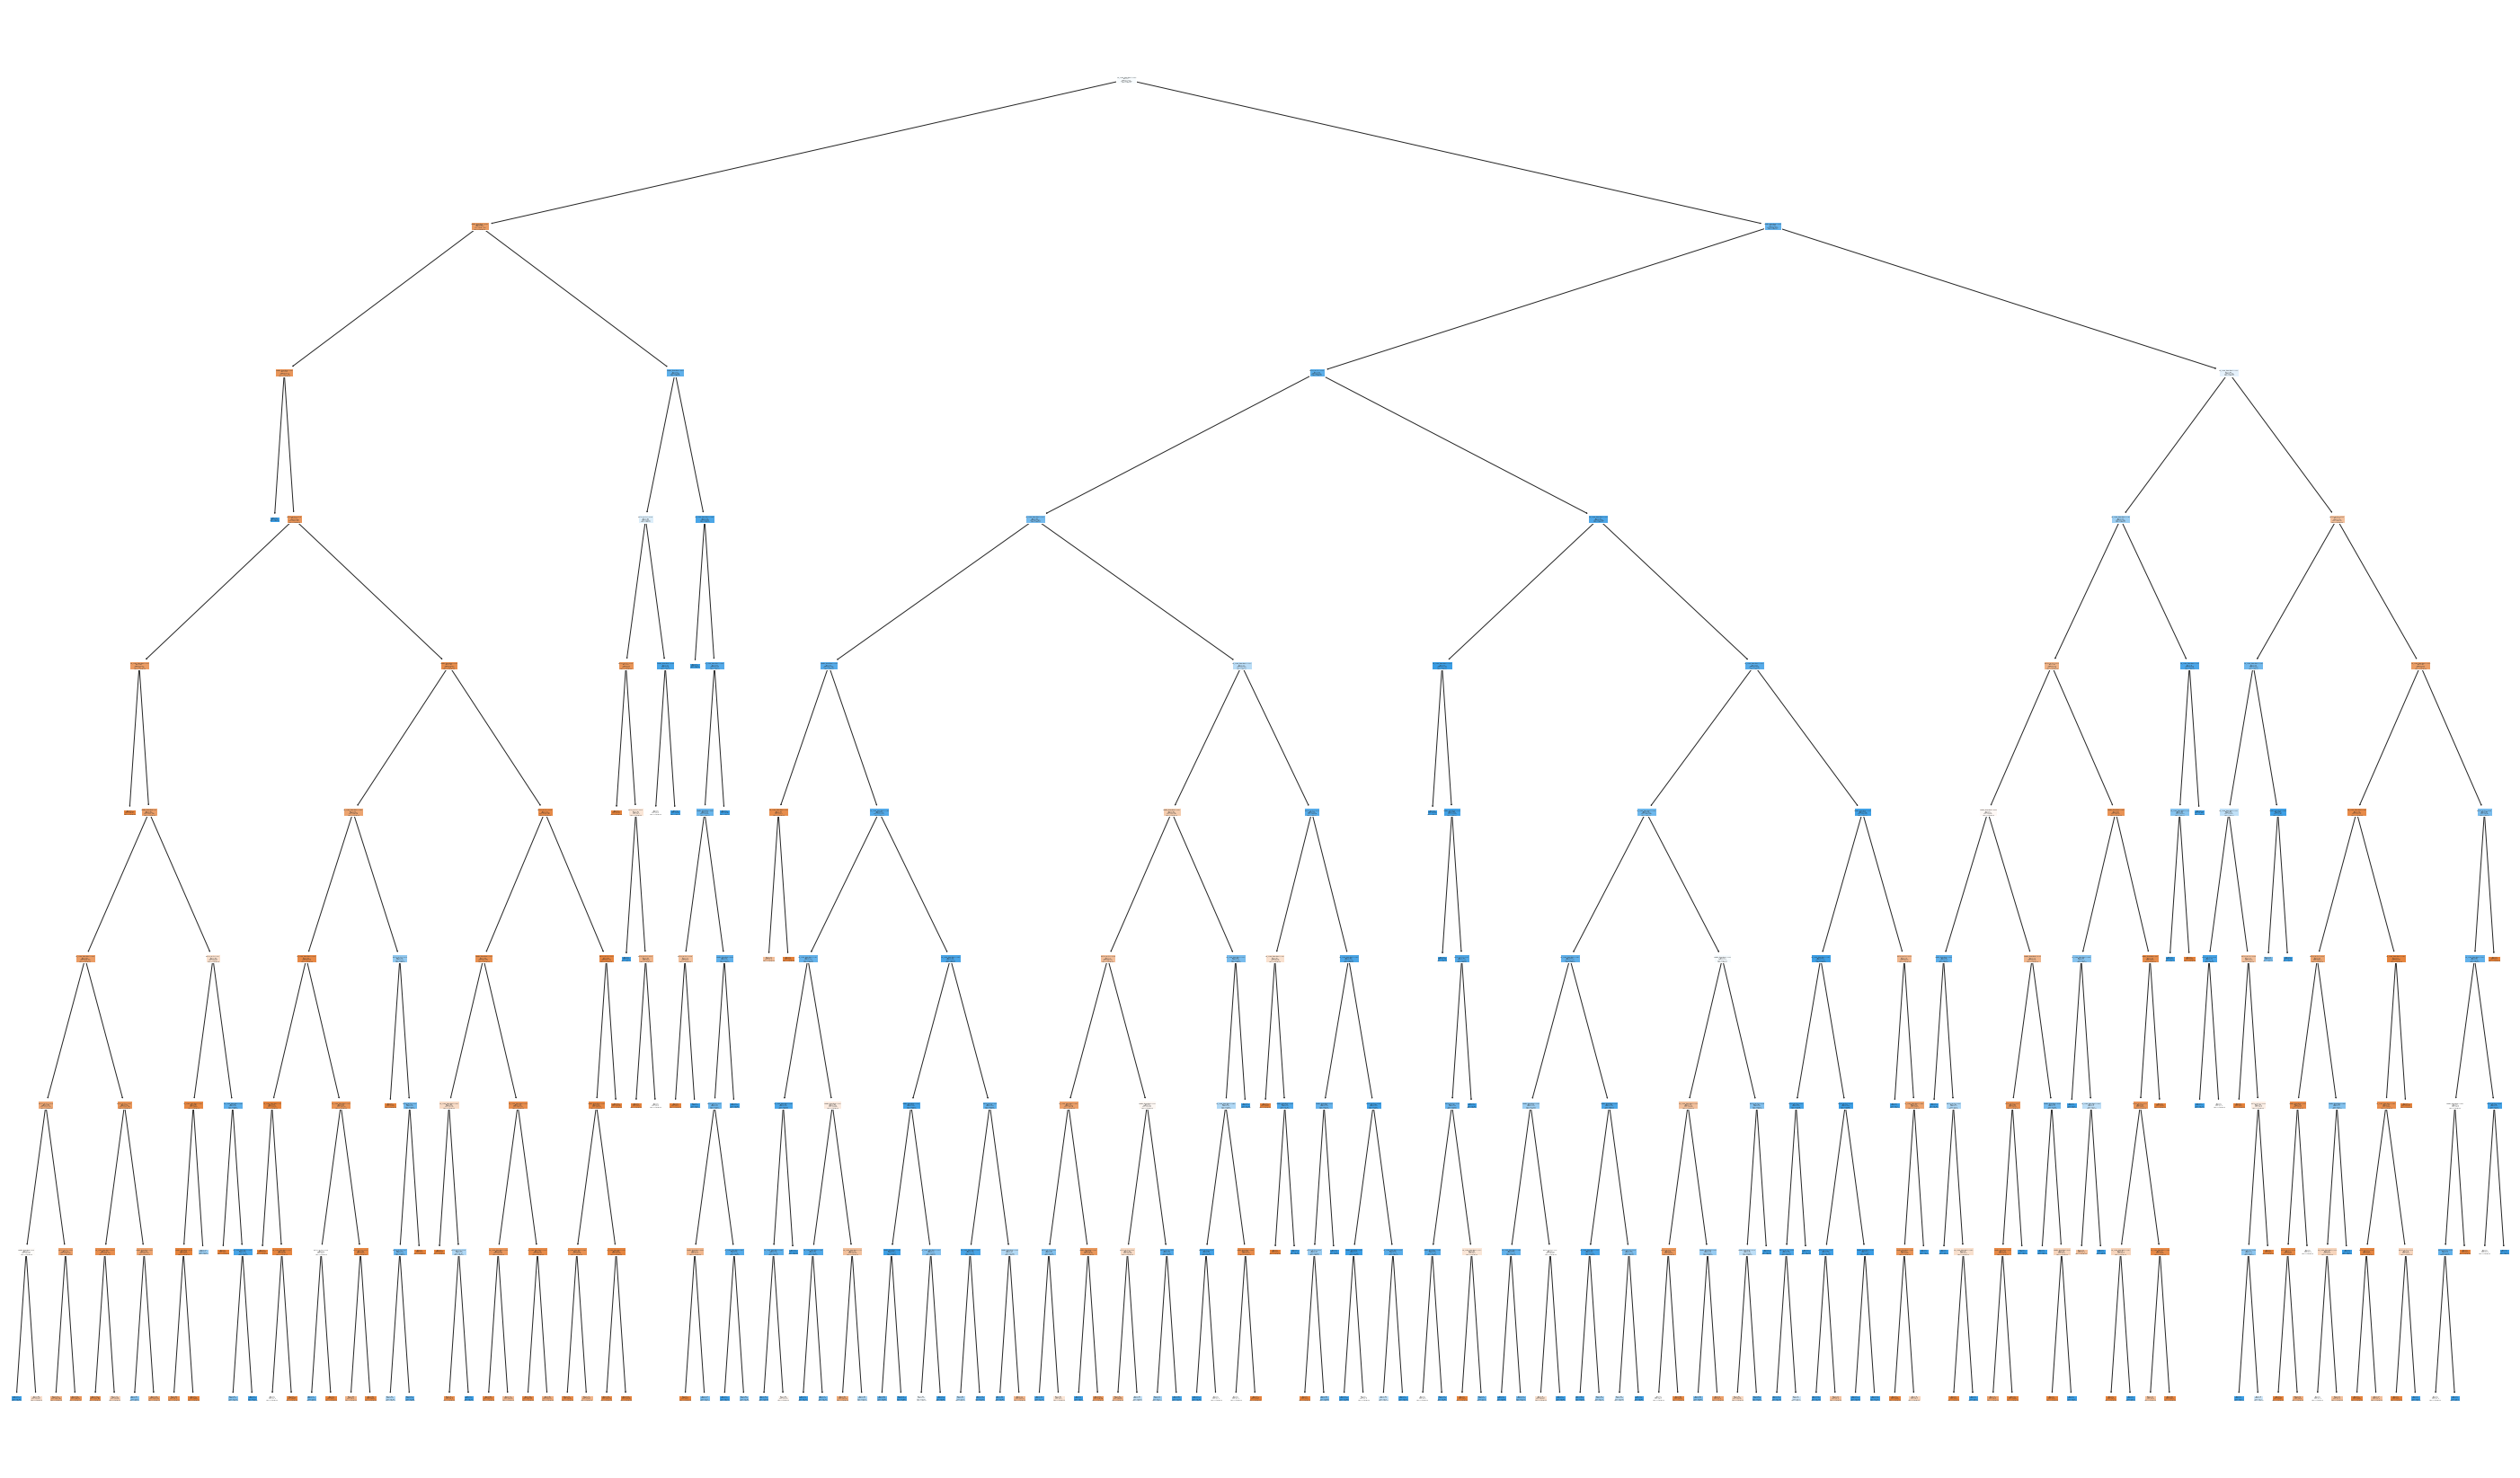

In [132]:
# Establish size of figure.
plt.figure(figsize = (50, 30))

# Plot our tree.
plot_tree(gs_dt.best_estimator_,
          feature_names = X_train.columns,
          class_names = ['Not upwelling', 'Upwelling'],
          filled = True);

In [133]:
print(export_text(gs_dt.best_estimator_,
                  list(X_train.columns)));

|--- sea_surface_temperature <= 10.82
|   |--- seawater_temperature <= 8.79
|   |   |--- seawater_temperature <= 7.28
|   |   |   |--- class: 1.0
|   |   |--- seawater_temperature >  7.28
|   |   |   |--- practical_salinity <= 33.91
|   |   |   |   |--- sea_surface_temperature <= 10.22
|   |   |   |   |   |--- class: -1.0
|   |   |   |   |--- sea_surface_temperature >  10.22
|   |   |   |   |   |--- seawater_temperature <= 8.70
|   |   |   |   |   |   |--- sea_surface_temperature <= 10.51
|   |   |   |   |   |   |   |--- practical_salinity <= 33.83
|   |   |   |   |   |   |   |   |--- seawater_temperature <= 8.48
|   |   |   |   |   |   |   |   |   |--- class: 1.0
|   |   |   |   |   |   |   |   |--- seawater_temperature >  8.48
|   |   |   |   |   |   |   |   |   |--- class: -1.0
|   |   |   |   |   |   |   |--- practical_salinity >  33.83
|   |   |   |   |   |   |   |   |--- practical_salinity <= 33.88
|   |   |   |   |   |   |   |   |   |--- class: -1.0
|   |   |   |   |   |   |   |

c:\users\derya\appdata\local\programs\python\python39\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass feature_names=['practical_salinity', 'seawater_temperature', 'sea_surface_temperature'] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


In [134]:
print(classification_report(y_test, gs_dt.predict(X_test)))

              precision    recall  f1-score   support

        -1.0       0.86      0.93      0.89      2175
         1.0       0.93      0.85      0.89      2253

    accuracy                           0.89      4428
   macro avg       0.89      0.89      0.89      4428
weighted avg       0.89      0.89      0.89      4428



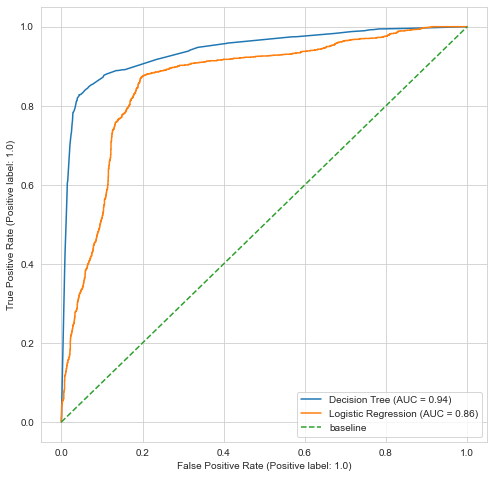

In [135]:
# ROC curve
fig, ax = plt.subplots(figsize=(8,8))

plot_roc_curve(gs_dt, X_test, y_test, ax=ax, name='Decision Tree')
plot_roc_curve(gs_lr, X_test, y_test, ax=ax, name='Logistic Regression')

# add worst case scenario line
plt.plot([0,1],[0,1], label='baseline', linestyle='--')

# add a legend
plt.legend();
# want AUC (area under curve) to be as close to 1 as possible

Interpretation goes here

#### Explore misclassified data

In [136]:
# Get indices of misclassified data
misclass_ind_dt = np.where(y_test != gs_dt_test_preds)
# misclass_ind_dt

In [62]:
X_test_times = df_resampled.iloc[X_test.index]['time']

In [63]:
X_test_times.iloc[misclass_ind_dt]

5513   2017-06-10 14:40:00
785    2017-01-24 03:20:00
8721   2017-09-12 01:40:00
1811   2017-02-18 04:40:00
7677   2017-08-08 13:40:00
               ...        
4639   2017-04-27 11:20:00
1727   2017-02-17 00:40:00
1577   2017-02-11 14:40:00
7889   2017-08-18 12:20:00
4535   2017-04-25 00:40:00
Name: time, Length: 290, dtype: datetime64[ns]

In [64]:
pd.DataFrame(X_test_times.iloc[misclass_ind_dt]).reset_index(drop=True)

,time
0,2017-06-10 14:40:00
1,2017-01-24 03:20:00
2,2017-09-12 01:40:00
3,2017-02-18 04:40:00
4,2017-08-08 13:40:00
...,...
285,2017-04-27 11:20:00
286,2017-02-17 00:40:00
287,2017-02-11 14:40:00
288,2017-08-18 12:20:00


In [65]:
frames_dt = [pd.DataFrame(X_test_times.iloc[misclass_ind_dt]), X_test.iloc[misclass_ind_dt], pd.DataFrame(y_test.iloc[misclass_ind_dt])]
misclass_df_dt = pd.concat(frames_dt, axis=1)

In [66]:
misclass_df_dt

,time,practical_salinity,seawater_temperature,sea_surface_temperature,upwelling_multi
5513,2017-06-10 14:40:00,33.940222,7.696991,13.998700,-1.0
785,2017-01-24 03:20:00,33.820590,8.753124,10.565350,1.0
8721,2017-09-12 01:40:00,33.936626,7.614938,14.107050,1.0
1811,2017-02-18 04:40:00,33.885423,8.248948,10.616853,1.0
7677,2017-08-08 13:40:00,33.956283,7.296255,14.209250,1.0
...,...,...,...,...,...
4639,2017-04-27 11:20:00,33.922389,7.868410,10.801706,1.0
1727,2017-02-17 00:40:00,33.902483,8.138169,10.264000,1.0
1577,2017-02-11 14:40:00,33.824268,8.435610,10.539088,1.0
7889,2017-08-18 12:20:00,33.982521,6.966109,14.465706,1.0


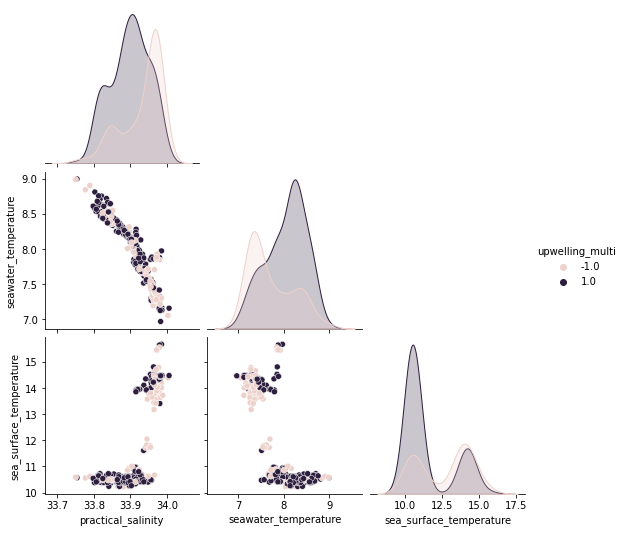

In [67]:
sns.pairplot(misclass_df_dt, corner=True, hue='upwelling_multi');

In [68]:
df_resampled['CUTI'] = df['CUTI']

df['CUTI']

0         1.731
1         1.731
2         1.731
3         1.731
4         1.731
          ...  
329194   -0.194
329195   -0.194
329196   -0.194
329197   -0.194
329198   -0.194
Name: CUTI, Length: 329199, dtype: float64

In [69]:
sns.set_style('whitegrid')

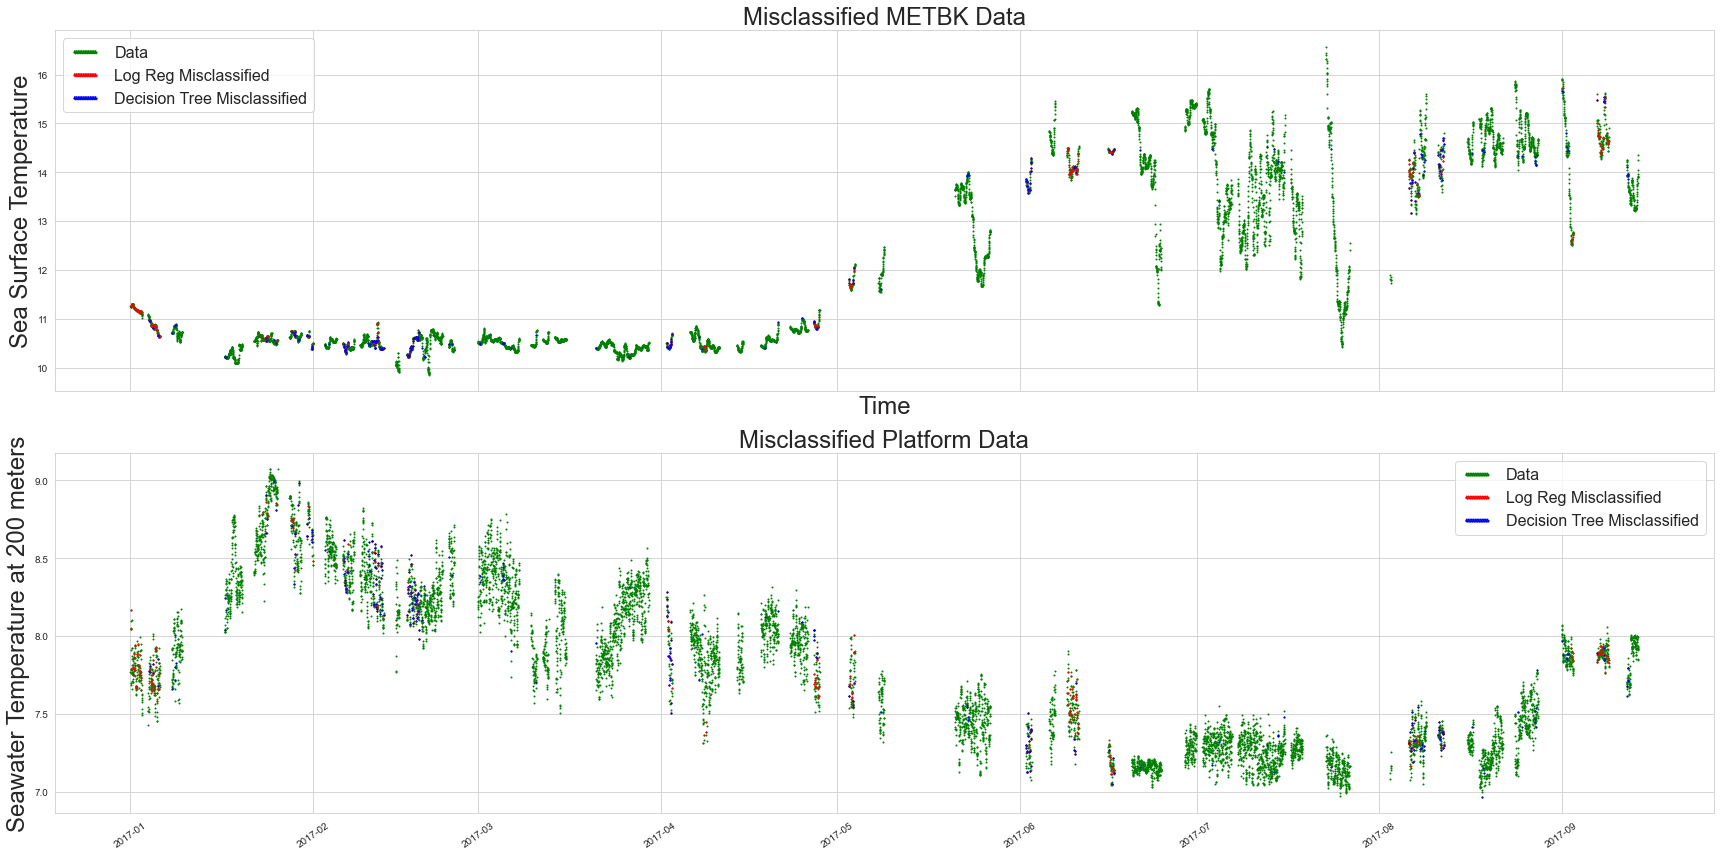

In [70]:
fig, (ax2, ax1) = plt.subplots(2,1, sharex=True, figsize = (24, 12)) 
ax1.scatter(x=df_resampled['time'], y=df_resampled['seawater_temperature'], c='g', s=1, label='Data')
ax1.set_ylabel('Seawater Temperature at 200 meters', size=24)
ax1.set_title('Misclassified Platform Data', size=24)

ax1.scatter(x=misclass_df_lr['time'], y=misclass_df_lr['seawater_temperature'], c='r', s=1, label='Log Reg Misclassified')
ax1.scatter(x=misclass_df_dt['time'], y=misclass_df_dt['seawater_temperature'], c='b', s=1, label='Decision Tree Misclassified')

ax2.scatter(x=df_resampled['time'], y=df_resampled['sea_surface_temperature'], c='g', s=1, label='Data')
ax2.set_xlabel('Time', size=24)
ax2.set_ylabel('Sea Surface Temperature', size=24)
ax2.set_title('Misclassified METBK Data', size=24)

ax2.scatter(x=misclass_df_lr['time'], y=misclass_df_lr['sea_surface_temperature'], c='r', s=1, label='Log Reg Misclassified')
ax2.scatter(x=misclass_df_dt['time'], y=misclass_df_dt['sea_surface_temperature'], c='b', s=1, label='Decision Tree Misclassified')

ax2.legend(fontsize=16, scatterpoints=40)
ax1.legend(fontsize=16, scatterpoints=40)
plt.xticks(rotation=35);
plt.tight_layout()
plt.savefig('../figures/misclassified_data.png')

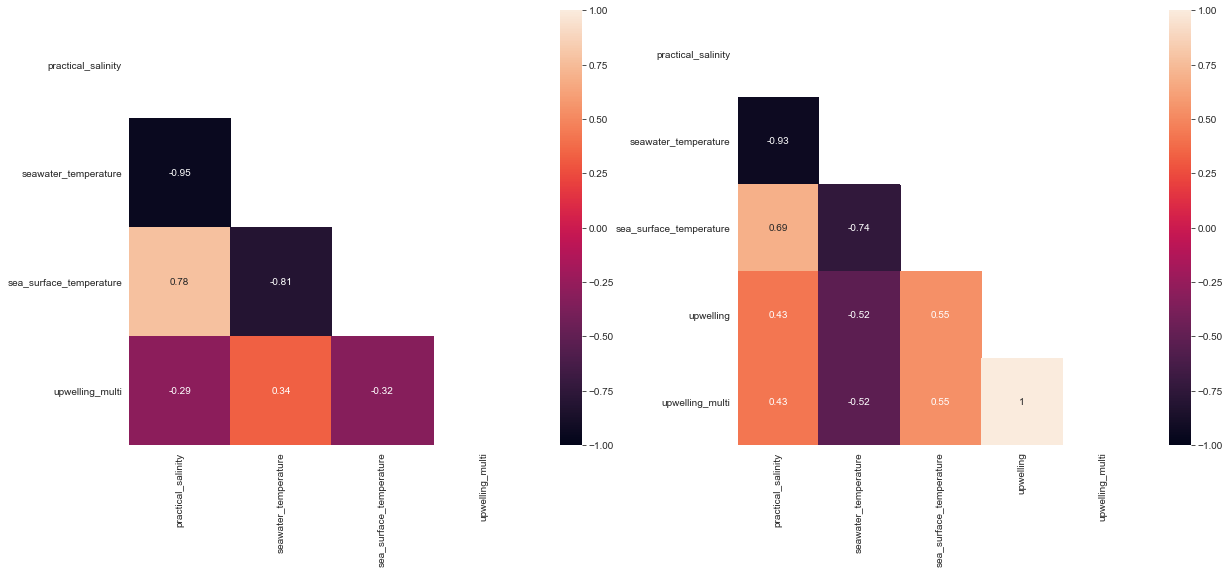

In [71]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,8))

corr = misclass_df_dt.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(misclass_df_dt.corr(), annot=True, vmin=-1, vmax=1, mask=mask, ax=ax1)

corr = df_resampled.drop(columns='CUTI').corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(df_resampled.drop(columns='CUTI').corr(), annot=True, vmin=-1, vmax=1, mask=mask, ax=ax2);